In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, log_loss
import operator
import json
from IPython import display
import os
import warnings

np.random.seed(0)
warnings.filterwarnings("ignore")
THRESHOLD = 4


|Task: To predict whether the user likes the mobile phone or not.    
Assumption: If the average rating of mobile >= threshold, then the user likes it, otherwise not.

Missing values: 'Also Known As'(459),'Applications'(421),'Audio Features'(437),'Bezel-less display'(266),'Browser'(449),'Build Material'(338),'Co-Processor'(451),'Display Colour'(457),'Mobile High-Definition Link(MHL)'(472),'Music'(447) 'Email','Fingerprint Sensor Position'(174),'Games'(446),'HDMI'(454),'Heart Rate Monitor'(467),'IRIS Scanner'(467), 'Optical Image Stabilisation'(219),'Other Facilities'(444),'Phone Book'(444),'Physical Aperture'(87),'Quick Charging'(122),'Ring Tone'(444),'Ruggedness'(430),SAR Value(315),'SIM 3'(472),'SMS'(470)', 'Screen Protection'(229),'Screen to Body Ratio (claimed by the brand)'(428),'Sensor'(242),'Software Based Aperture'(473), 'Special Features'(459),'Standby time'(334),'Stylus'(473),'TalkTime'(259), 'USB Type-C'(374),'Video Player'(456), 'Video Recording Features'(458),'Waterproof'(398),'Wireless Charging','USB OTG Support'(159), 'Video ,'Recording'(113),'Java'(471),'Browser'(448)

Very low variance: 'Architecture'(most entries are 64-bit),'Audio Jack','GPS','Loudspeaker','Network','Network Support','Other Sensors'(28),'SIM Size', 'VoLTE'

Multivalued: 'Colours','Custom UI','Model'(1),'Other Sensors','Launch Date'

Not important: 'Bluetooth', 'Settings'(75),'Wi-Fi','Wi-Fi Features'

Doubtful: 'Aspect Ratio','Autofocus','Brand','Camera Features','Fingerprint Sensor'(very few entries are missing), 'Fingerprint Sensor Position', 'Graphics'(multivalued),'Image resolution'(multivalued),'SIM Size','Sim Slot(s)', 'User Available Storage', 'SIM 1', 'SIM 2','Shooting Modes', 'Touch Screen'(24), 'USB Connectivity'

To check: 'Display Type','Expandable Memory','FM Radio'

High Correlation with other features 'SIM Slot(s)' high correlation with SIM1 'Weight' has high high correlation with capacity , screen-to-body ratio 'Height' - screen size is also there

Given a mobile, we can't directly get these features 'Rating Count', 'Review Count'

Keeping: 'Capacity','Flash'(17),'Height'(22),'Internal Memory'(20, require cleaning),'Operating System'(25, require cleaning), 'Pixel Density'(1, clean it),'Processor'(22, clean it), 'RAM'(17, clean), 'Rating','Resolution'(cleaning), 'Screen Resolution','Screen Size', 'Thickness'(22), 'Type','User Replaceable','Weight'(cleaning),'Sim Size'(), 'Other Sensors'(28), 'Screen to Body Ratio (calculated)','Width',

In [3]:
!cd dataset

In [4]:
pwd 

'C:\\Users\\suraj\\Desktop\\mtech_sem2\\GUVI DeepLearning\\Mobile_Like_Dislike_MPNeuron'

In [5]:
ls dataset\

 Volume in drive C has no label.
 Volume Serial Number is 1A29-EE7C

 Directory of C:\Users\suraj\Desktop\mtech_sem2\GUVI DeepLearning\Mobile_Like_Dislike_MPNeuron\dataset

11-04-2020  17:27    <DIR>          .
11-04-2020  17:27    <DIR>          ..
11-04-2020  17:27           377,773 test.csv
11-04-2020  17:27         1,120,925 train.csv
               2 File(s)      1,498,698 bytes
               2 Dir(s)  110,902,661,120 bytes free


In [6]:
train = pd.read_csv('./dataset/train.csv')
test= pd.read_csv('./dataset/test.csv')

In [7]:
print(train.shape, test.shape)

(355, 99) (119, 98)


In [8]:
# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 355
Number of features in train: 99
Number of data points in test: 119
Number of features in test: 98


In [9]:
def data_clean(data):
    
    # Let's first remove all missing value features
    columns_to_remove = ['Also Known As','Applications','Audio Features','Bezel-less display'
                         'Browser','Build Material','Co-Processor','Browser'
                         'Display Colour','Mobile High-Definition Link(MHL)',
                         'Music', 'Email','Fingerprint Sensor Position',
                         'Games','HDMI','Heart Rate Monitor','IRIS Scanner', 
                         'Optical Image Stabilisation','Other Facilities',
                         'Phone Book','Physical Aperture','Quick Charging',
                         'Ring Tone','Ruggedness','SAR Value','SIM 3','SMS',
                         'Screen Protection','Screen to Body Ratio (claimed by the brand)',
                         'Sensor','Software Based Aperture', 'Special Features',
                         'Standby time','Stylus','TalkTime', 'USB Type-C',
                         'Video Player', 'Video Recording Features','Waterproof',
                         'Wireless Charging','USB OTG Support', 'Video Recording','Java']

    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    #Features having very low variance 
    columns_to_remove = ['Architecture','Audio Jack','GPS','Loudspeaker','Network','Network Support','VoLTE']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    # Multivalued:
    columns_to_remove = ['Architecture','Launch Date','Audio Jack','GPS','Loudspeaker','Network','Network Support','VoLTE', 'Custom UI']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    # Not much important
    columns_to_remove = ['Bluetooth', 'Settings','Wi-Fi','Wi-Fi Features']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]
    
    return data

# Removing feature

Before cleaning the data

In [11]:
print(train.columns)

Index(['PhoneId', 'Also Known As', 'Applications', 'Architecture',
       'Aspect Ratio', 'Audio Features', 'Audio Jack', 'Autofocus',
       'Bezel-less display', 'Bluetooth', 'Brand', 'Browser', 'Build Material',
       'Camera Features', 'Capacity', 'Chipset', 'Co-Processor', 'Colours',
       'Custom UI', 'Display Colour', 'Display Type', 'Email',
       'Expandable Memory', 'FM Radio', 'Fingerprint Sensor',
       'Fingerprint Sensor Position', 'Flash', 'GPS', 'Games', 'Graphics',
       'HDMI', 'Heart Rate Monitor', 'Height', 'IRIS Scanner',
       'Image Resolution', 'Internal Memory', 'Java', 'Launch Date',
       'Loudspeaker', 'Mobile High-Definition Link(MHL)', 'Model', 'Music',
       'NFC', 'Network', 'Network Support', 'Operating System',
       'Optical Image Stabilisation', 'Other Facilities', 'Other Sensors',
       'Phone Book', 'Physical Aperture', 'Pixel Density', 'Processor',
       'Quick Charging', 'RAM', 'Rating Count', 'Resolution', 'Review Count',
       'Ring

In [12]:
train = data_clean(train)
test = data_clean(test)

After cleaning Data

In [13]:
print(train.columns)

Index(['Screen Size', 'SIM Slot(s)', 'Model', 'Processor', 'Display Type',
       'Touch Screen', 'Screen to Body Ratio (calculated)', 'RAM',
       'Expandable Memory', 'Graphics', 'Flash', 'User Available Storage',
       'Other Sensors', 'Chipset', 'Operating System', 'Width', 'Browser',
       'Colours', 'NFC', 'SIM 2', 'Height', 'Display Colour',
       'Bezel-less display', 'Brand', 'Image Resolution', 'User Replaceable',
       'Aspect Ratio', 'Pixel Density', 'Resolution', 'Camera Features',
       'PhoneId', 'Internal Memory', 'Shooting Modes', 'Rating',
       'Screen Resolution', 'Autofocus', 'USB Connectivity', 'Capacity',
       'Review Count', 'Fingerprint Sensor', 'Thickness', 'Weight', 'SIM 1',
       'SIM Size', 'Type', 'Rating Count', 'FM Radio'],
      dtype='object')


In [14]:
train = train[(train.isnull().sum(axis=1) <= 15)]
# You shouldn't remove data points from test set
#test = test[(test.isnull().sum(axis=1) <= 15)]

In [15]:
# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 341
Number of features in train: 47
Number of data points in test: 119
Number of features in test: 46


In [16]:
train.head()

,Screen Size,SIM Slot(s),Model,Processor,Display Type,Touch Screen,Screen to Body Ratio (calculated),RAM,Expandable Memory,Graphics,...,Capacity,Review Count,Fingerprint Sensor,Thickness,Weight,SIM 1,SIM Size,Type,Rating Count,FM Radio
0,6.26 inches (15.9 cm),"Dual SIM, GSM+GSM, Dual VoLTE",Redmi Note 6 Pro,"Octa core (1.8 GHz, Quad core, Kryo 260 + 1.6 ...",IPS LCD,"Capacitive Touchscreen, Multi-touch",80.68 %,4 GB Excellent ▾RAM compared to11 - 17 K Phone...,Up to 256 GB,Adreno 509,...,4000 mAh,17138,yes,8.2 mm Very Good ▾Thickness compared to11 - 17...,182 grams Below Average ▾Weight compared to11 ...,4G Bands:TD-LTE 2300(band 40) / 2500(band 41) ...,"SIM1: Nano, SIM2: Nano (Hybrid)",Li-Polymer,172274,NaN
1,6.2 inches (15.75 cm),"Dual SIM, GSM+GSM, Dual VoLTE",2,"Octa core, 1.8 GHz, Cortex A53 Average ▾Proces...",IPS LCD,"Capacitive Touchscreen, Multi-touch",80.85 %,3 GB Excellent ▾RAM compared to8 - 12 K Phones...,Up to 256 GB,Adreno 506,...,4230 mAh,38252,yes,8.2 mm Very Good ▾Thickness compared to8 - 12 ...,168 grams Average ▾Weight compared to8 - 12 K ...,4G Bands:TD-LTE 2600(band 38) / 2300(band 40) ...,"SIM1: Nano, SIM2: Nano",Li-ion,339447,NaN
2,6.3 inches (16 cm),"Dual SIM, GSM+GSM, Dual VoLTE",U1,"Octa core (2.1 GHz, Quad core, Cortex A73 + 2 ...",IPS LCD,"Capacitive Touchscreen, Multi-touch",83.68 %,3 GB Excellent ▾RAM compared to10 - 14 K Phone...,Up to 256 GB,Mali-G72 MP3,...,3500 mAh,1151,yes,8 mm Very Good ▾Thickness compared to10 - 14 K...,168 grams Average ▾Weight compared to10 - 14 K...,4G Bands:TD-LTE 2600(band 38) / 2300(band 40) ...,"SIM1: Nano, SIM2: Nano",Li-ion,1149,yes
3,6.0 inches (15.24 cm),"Dual SIM, GSM+GSM",Galaxy A7 2018,"Octa core (2.2 GHz, Dual core, Cortex A73 + 1....",Super AMOLED,"Capacitive Touchscreen, Multi-touch",74.78 %,4 GB Excellent ▾RAM compared to15 - 23 K Phone...,Up to 512 GB,Mali-G71 MP2,...,3300 mAh,779,yes,7.5 mm Very Good ▾Thickness compared to15 - 23...,169 grams Average ▾Weight compared to15 - 23 K...,4G Bands:TD-LTE 2600(band 38) / 2300(band 40) ...,"SIM1: Nano, SIM2: Nano",Li-ion,6026,yes
4,6.5 inches (16.51 cm),"Dual SIM, GSM+GSM, Dual VoLTE",8X,"Octa core (2.2 GHz, Quad core, Cortex A73 + 1....",IPS LCD,"Capacitive Touchscreen, Multi-touch",84.23 %,4 GB Excellent ▾RAM compared to12 - 18 K Phone...,Up to 400 GB,Mali-G51 MP4,...,3750 mAh,5177,yes,7.8 mm Very Good ▾Thickness compared to12 - 18...,175 grams Below Average ▾Weight compared to12 ...,4G Bands:TD-LTE 2300(band 40) FD-LTE 1800(band...,"SIM1: Nano, SIM2: Nano",Li-Polymer,5175,yes


# Filling Missing Values

In [17]:
def for_integer(test):
    try:
        test = test.strip()
        return int(test.split(' ')[0])
    except IOError:
           pass
    except ValueError:
        pass
    except:
        pass

def for_string(test):
    try:
        test = test.strip()
        return (test.split(' ')[0])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass

def for_float(test):
    try:
        test = test.strip()
        return float(test.split(' ')[0])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass
def find_freq(test):
    try:
        test = test.strip()
        test = test.split(' ')
        if test[2][0] == '(':
            return float(test[2][1:])
        return float(test[2])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass

    
def for_Internal_Memory(test):
    try:
        test = test.strip()
        test = test.split(' ')
        if test[1] == 'GB':
            return int(test[0])
        if test[1] == 'MB':
#             print("here")
            return (int(test[0]) * 0.001)
    except IOError:
           pass
    except ValueError:
        pass
    except:
        pass
    
def find_freq(test):
    try:
        test = test.strip()
        test = test.split(' ')
        if test[2][0] == '(':
            return float(test[2][1:])
        return float(test[2])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass

In [18]:
def data_clean_2(x):
    data = x.copy()
    
    data['Capacity'] = data['Capacity'].apply(for_integer)

    data['Height'] = data['Height'].apply(for_float)
    data['Height'] = data['Height'].fillna(data['Height'].mean())

    data['Internal Memory'] = data['Internal Memory'].apply(for_Internal_Memory)

    data['Pixel Density'] = data['Pixel Density'].apply(for_integer)

    data['Internal Memory'] = data['Internal Memory'].fillna(data['Internal Memory'].median())
    data['Internal Memory'] = data['Internal Memory'].astype(int)

    data['RAM'] = data['RAM'].apply(for_Internal_Memory)
    data['RAM'] = data['RAM'].fillna(data['RAM'].median())
    data['RAM'] = data['RAM'].astype(int)

    data['Resolution'] = data['Resolution'].apply(for_integer)
    data['Resolution'] = data['Resolution'].fillna(data['Resolution'].median())
    data['Resolution'] = data['Resolution'].astype(int)

    data['Screen Size'] = data['Screen Size'].apply(for_float)

    data['Thickness'] = data['Thickness'].apply(for_float)
    data['Thickness'] = data['Thickness'].fillna(data['Thickness'].mean())
    data['Thickness'] = data['Thickness'].round(2)

    data['Type'] = data['Type'].fillna('Li-Polymer')

    data['Screen to Body Ratio (calculated)'] = data['Screen to Body Ratio (calculated)'].apply(for_float)
    data['Screen to Body Ratio (calculated)'] = data['Screen to Body Ratio (calculated)'].fillna(data['Screen to Body Ratio (calculated)'].mean())
    data['Screen to Body Ratio (calculated)'] = data['Screen to Body Ratio (calculated)'].round(2)

    data['Width'] = data['Width'].apply(for_float)
    data['Width'] = data['Width'].fillna(data['Width'].mean())
    data['Width'] = data['Width'].round(2)

    data['Flash'][data['Flash'].isnull() == True] = "Other"

    data['User Replaceable'][data['User Replaceable'].isnull() == True] = "Other"

    data['Num_cores'] = data['Processor'].apply(for_string)
    data['Num_cores'][data['Num_cores'].isnull() == True] = "Other"


    data['Processor_frequency'] = data['Processor'].apply(find_freq)
    #because there is one entry with 208MHz values, to convert it to GHz
    data['Processor_frequency'][data['Processor_frequency'] > 200] = 0.208
    data['Processor_frequency'] = data['Processor_frequency'].fillna(data['Processor_frequency'].mean())
    data['Processor_frequency'] = data['Processor_frequency'].round(2)

    data['Camera Features'][data['Camera Features'].isnull() == True] = "Other"

    #simplifyig Operating System to os_name for simplicity
    data['os_name'] = data['Operating System'].apply(for_string)
    data['os_name'][data['os_name'].isnull() == True] = "Other"

    data['Sim1'] = data['SIM 1'].apply(for_string)

    data['SIM Size'][data['SIM Size'].isnull() == True] = "Other"

    data['Image Resolution'][data['Image Resolution'].isnull() == True] = "Other"

    data['Fingerprint Sensor'][data['Fingerprint Sensor'].isnull() == True] = "Other"

    data['Expandable Memory'][data['Expandable Memory'].isnull() == True] = "No"

    data['Weight'] = data['Weight'].apply(for_integer)
    data['Weight'] = data['Weight'].fillna(data['Weight'].mean())
    data['Weight'] = data['Weight'].astype(int)

    data['SIM 2'] = data['SIM 2'].apply(for_string)
    data['SIM 2'][data['SIM 2'].isnull() == True] = "Other"
    
    return data

In [19]:
train1 = train.copy()
train = data_clean_2(train)

test = data_clean_2(test)

# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 341
Number of features in train: 51
Number of data points in test: 119
Number of features in test: 50


In [20]:
train.columns

Index(['Screen Size', 'SIM Slot(s)', 'Model', 'Processor', 'Display Type',
       'Touch Screen', 'Screen to Body Ratio (calculated)', 'RAM',
       'Expandable Memory', 'Graphics', 'Flash', 'User Available Storage',
       'Other Sensors', 'Chipset', 'Operating System', 'Width', 'Browser',
       'Colours', 'NFC', 'SIM 2', 'Height', 'Display Colour',
       'Bezel-less display', 'Brand', 'Image Resolution', 'User Replaceable',
       'Aspect Ratio', 'Pixel Density', 'Resolution', 'Camera Features',
       'PhoneId', 'Internal Memory', 'Shooting Modes', 'Rating',
       'Screen Resolution', 'Autofocus', 'USB Connectivity', 'Capacity',
       'Review Count', 'Fingerprint Sensor', 'Thickness', 'Weight', 'SIM 1',
       'SIM Size', 'Type', 'Rating Count', 'FM Radio', 'Num_cores',
       'Processor_frequency', 'os_name', 'Sim1'],
      dtype='object')

In [21]:
train.head()

,Screen Size,SIM Slot(s),Model,Processor,Display Type,Touch Screen,Screen to Body Ratio (calculated),RAM,Expandable Memory,Graphics,...,Weight,SIM 1,SIM Size,Type,Rating Count,FM Radio,Num_cores,Processor_frequency,os_name,Sim1
0,6.26,"Dual SIM, GSM+GSM, Dual VoLTE",Redmi Note 6 Pro,"Octa core (1.8 GHz, Quad core, Kryo 260 + 1.6 ...",IPS LCD,"Capacitive Touchscreen, Multi-touch",80.68,4,Up to 256 GB,Adreno 509,...,182,4G Bands:TD-LTE 2300(band 40) / 2500(band 41) ...,"SIM1: Nano, SIM2: Nano (Hybrid)",Li-Polymer,172274,NaN,Octa,1.8,Android,4G
1,6.20,"Dual SIM, GSM+GSM, Dual VoLTE",2,"Octa core, 1.8 GHz, Cortex A53 Average ▾Proces...",IPS LCD,"Capacitive Touchscreen, Multi-touch",80.85,3,Up to 256 GB,Adreno 506,...,168,4G Bands:TD-LTE 2600(band 38) / 2300(band 40) ...,"SIM1: Nano, SIM2: Nano",Li-ion,339447,NaN,Octa,1.8,Android,4G
2,6.30,"Dual SIM, GSM+GSM, Dual VoLTE",U1,"Octa core (2.1 GHz, Quad core, Cortex A73 + 2 ...",IPS LCD,"Capacitive Touchscreen, Multi-touch",83.68,3,Up to 256 GB,Mali-G72 MP3,...,168,4G Bands:TD-LTE 2600(band 38) / 2300(band 40) ...,"SIM1: Nano, SIM2: Nano",Li-ion,1149,yes,Octa,2.1,Android,4G
3,6.00,"Dual SIM, GSM+GSM",Galaxy A7 2018,"Octa core (2.2 GHz, Dual core, Cortex A73 + 1....",Super AMOLED,"Capacitive Touchscreen, Multi-touch",74.78,4,Up to 512 GB,Mali-G71 MP2,...,169,4G Bands:TD-LTE 2600(band 38) / 2300(band 40) ...,"SIM1: Nano, SIM2: Nano",Li-ion,6026,yes,Octa,2.2,Android,4G
4,6.50,"Dual SIM, GSM+GSM, Dual VoLTE",8X,"Octa core (2.2 GHz, Quad core, Cortex A73 + 1....",IPS LCD,"Capacitive Touchscreen, Multi-touch",84.23,4,Up to 400 GB,Mali-G51 MP4,...,175,4G Bands:TD-LTE 2300(band 40) FD-LTE 1800(band...,"SIM1: Nano, SIM2: Nano",Li-Polymer,5175,yes,Octa,2.2,Android,4G


Not very important feature

In [22]:
def data_clean_3(x):
    
    data = x.copy()

    columns_to_remove = ['User Available Storage','SIM Size','Chipset','Processor','Autofocus','Aspect Ratio','Touch Screen',
                        'Bezel-less display','Operating System','SIM 1','USB Connectivity','Other Sensors','Graphics','FM Radio',
                        'NFC','Shooting Modes','Browser','Display Colour' ]

    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]


    columns_to_remove = [ 'Screen Resolution','User Replaceable','Camera Features',
                        'Thickness', 'Display Type']

    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]


    columns_to_remove = ['Fingerprint Sensor', 'Flash', 'Rating Count', 'Review Count','Image Resolution','Type','Expandable Memory',\
                        'Colours','Width','Model']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    return data

In [23]:
train = data_clean_3(train)
test = data_clean_3(test)

# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 341
Number of features in train: 18
Number of data points in test: 119
Number of features in test: 17


In [24]:
train[train['PhoneId']==56]

,Capacity,Screen Size,SIM Slot(s),Num_cores,PhoneId,Processor_frequency,Internal Memory,os_name,Sim1,SIM 2,Height,Weight,Rating,Screen to Body Ratio (calculated),RAM,Brand,Pixel Density,Resolution
40,4000,5.5,"Dual SIM, GSM+GSM",Deca,56,2.3,64,Android,4G,4G,154.5,180,3.8,70.95,4,Lenovo,401,13


In [25]:
train.columns

Index(['Capacity', 'Screen Size', 'SIM Slot(s)', 'Num_cores', 'PhoneId',
       'Processor_frequency', 'Internal Memory', 'os_name', 'Sim1', 'SIM 2',
       'Height', 'Weight', 'Rating', 'Screen to Body Ratio (calculated)',
       'RAM', 'Brand', 'Pixel Density', 'Resolution'],
      dtype='object')

In [26]:
test.columns

Index(['Capacity', 'Screen Size', 'SIM Slot(s)', 'Num_cores', 'PhoneId',
       'Processor_frequency', 'Internal Memory', 'os_name', 'Sim1', 'SIM 2',
       'Height', 'Weight', 'Screen to Body Ratio (calculated)', 'RAM', 'Brand',
       'Pixel Density', 'Resolution'],
      dtype='object')

In [27]:
# one hot encoding

train_ids = train['PhoneId']
test_ids = test['PhoneId']

cols = list(test.columns)
cols.remove('PhoneId')
cols.insert(0, 'PhoneId')

combined = pd.concat([train.drop('Rating', axis=1)[cols], test[cols]])
print(combined.shape)
print(combined.columns)

combined = pd.get_dummies(combined)
print(combined.shape)
print(combined.columns)

train_new = combined[combined['PhoneId'].isin(train_ids)]
test_new = combined[combined['PhoneId'].isin(test_ids)]

(460, 17)
Index(['PhoneId', 'Capacity', 'Screen Size', 'SIM Slot(s)', 'Num_cores',
       'Processor_frequency', 'Internal Memory', 'os_name', 'Sim1', 'SIM 2',
       'Height', 'Weight', 'Screen to Body Ratio (calculated)', 'RAM', 'Brand',
       'Pixel Density', 'Resolution'],
      dtype='object')
(460, 87)
Index(['PhoneId', 'Capacity', 'Screen Size', 'Processor_frequency',
       'Internal Memory', 'Height', 'Weight',
       'Screen to Body Ratio (calculated)', 'RAM', 'Pixel Density',
       'Resolution', 'SIM Slot(s)_Dual SIM, GSM+CDMA',
       'SIM Slot(s)_Dual SIM, GSM+GSM',
       'SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE',
       'SIM Slot(s)_Single SIM, GSM', 'Num_cores_312', 'Num_cores_Deca',
       'Num_cores_Dual', 'Num_cores_Hexa', 'Num_cores_Octa', 'Num_cores_Other',
       'Num_cores_Quad', 'Num_cores_Tru-Octa', 'os_name_Android',
       'os_name_Blackberry', 'os_name_KAI', 'os_name_Nokia', 'os_name_Other',
       'os_name_Tizen', 'os_name_iOS', 'Sim1_2G', 'Sim1_3G', 'S

In [28]:
#pd.set_option('display.height',1000)
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',100)
pd.set_option('display.width',1000)
train_new.head()

,PhoneId,Capacity,Screen Size,Processor_frequency,Internal Memory,Height,Weight,Screen to Body Ratio (calculated),RAM,Pixel Density,Resolution,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",Num_cores_312,Num_cores_Deca,Num_cores_Dual,Num_cores_Hexa,Num_cores_Octa,Num_cores_Other,Num_cores_Quad,Num_cores_Tru-Octa,os_name_Android,os_name_Blackberry,os_name_KAI,os_name_Nokia,os_name_Other,os_name_Tizen,os_name_iOS,Sim1_2G,Sim1_3G,Sim1_4G,SIM 2_2G,SIM 2_3G,SIM 2_4G,SIM 2_Other,Brand_10.or,Brand_Apple,Brand_Asus,Brand_Billion,Brand_Blackberry,Brand_Comio,Brand_Coolpad,Brand_Do,Brand_Gionee,Brand_Google,Brand_HTC,Brand_Honor,Brand_Huawei,Brand_InFocus,Brand_Infinix,Brand_Intex,Brand_Itel,Brand_Jivi,Brand_Karbonn,Brand_LG,Brand_Lava,Brand_LeEco,Brand_Lenovo,Brand_Lephone,Brand_Lyf,Brand_Meizu,Brand_Micromax,Brand_Mobiistar,Brand_Moto,Brand_Motorola,Brand_Nokia,Brand_Nubia,Brand_OPPO,Brand_OnePlus,Brand_Oppo,Brand_Panasonic,Brand_Razer,Brand_Realme,Brand_Reliance,Brand_Samsung,Brand_Sony,Brand_Spice,Brand_Tecno,Brand_Ulefone,Brand_VOTO,Brand_Vivo,Brand_Xiaomi,Brand_Xiaomi Poco,Brand_Yu,Brand_iVooMi
0,0,4000,6.26,1.8,64,157.9,182,80.68,4,403,20,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,1,4230,6.20,1.8,32,156.2,168,80.85,3,271,8,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,2,3500,6.30,2.1,32,157.0,168,83.68,3,409,25,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,4,3300,6.00,2.2,64,159.8,169,74.78,4,411,24,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,3750,6.50,2.2,64,160.4,175,84.23,4,396,16,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [29]:
train_new = train_new.merge(train[['PhoneId', 'Rating']], on='PhoneId')

In [30]:
train_new.head()

,PhoneId,Capacity,Screen Size,Processor_frequency,Internal Memory,Height,Weight,Screen to Body Ratio (calculated),RAM,Pixel Density,Resolution,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",Num_cores_312,Num_cores_Deca,Num_cores_Dual,Num_cores_Hexa,Num_cores_Octa,Num_cores_Other,Num_cores_Quad,Num_cores_Tru-Octa,os_name_Android,os_name_Blackberry,os_name_KAI,os_name_Nokia,os_name_Other,os_name_Tizen,os_name_iOS,Sim1_2G,Sim1_3G,Sim1_4G,SIM 2_2G,SIM 2_3G,SIM 2_4G,SIM 2_Other,Brand_10.or,Brand_Apple,Brand_Asus,Brand_Billion,Brand_Blackberry,Brand_Comio,Brand_Coolpad,Brand_Do,Brand_Gionee,Brand_Google,Brand_HTC,Brand_Honor,Brand_Huawei,Brand_InFocus,Brand_Infinix,Brand_Intex,Brand_Itel,Brand_Jivi,Brand_Karbonn,Brand_LG,Brand_Lava,Brand_LeEco,Brand_Lenovo,Brand_Lephone,Brand_Lyf,Brand_Meizu,Brand_Micromax,Brand_Mobiistar,Brand_Moto,Brand_Motorola,Brand_Nokia,Brand_Nubia,Brand_OPPO,Brand_OnePlus,Brand_Oppo,Brand_Panasonic,Brand_Razer,Brand_Realme,Brand_Reliance,Brand_Samsung,Brand_Sony,Brand_Spice,Brand_Tecno,Brand_Ulefone,Brand_VOTO,Brand_Vivo,Brand_Xiaomi,Brand_Xiaomi Poco,Brand_Yu,Brand_iVooMi,Rating
0,0,4000,6.26,1.8,64,157.9,182,80.68,4,403,20,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,4.5
1,1,4230,6.20,1.8,32,156.2,168,80.85,3,271,8,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,4.5
2,2,3500,6.30,2.1,32,157.0,168,83.68,3,409,25,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,4.4
3,4,3300,6.00,2.2,64,159.8,169,74.78,4,411,24,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,4.3
4,5,3750,6.50,2.2,64,160.4,175,84.23,4,396,16,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.4


In [31]:
# check the number of features and data points in train
print("Number of data points in train: %d" % train_new.shape[0])
print("Number of features in train: %d" % train_new.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test_new.shape[0])
print("Number of features in test: %d" % test_new.shape[1])

Number of data points in train: 341
Number of features in train: 88
Number of data points in test: 119
Number of features in test: 87


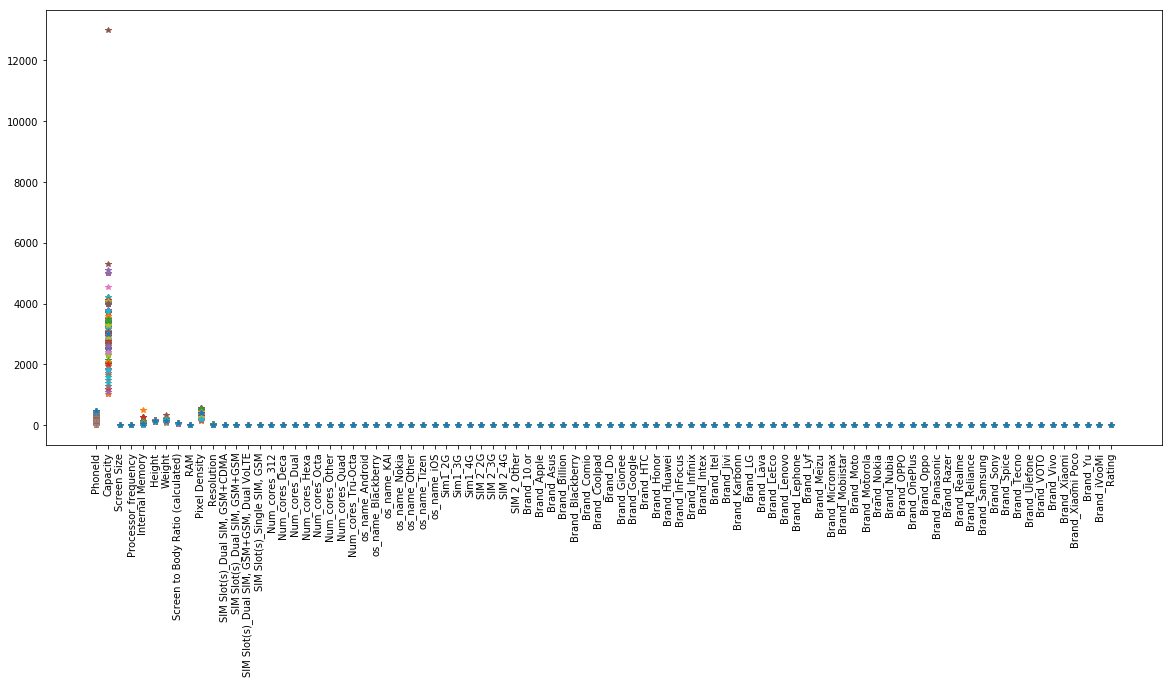

In [32]:
plt.figure(figsize=(20, 8))
plt.plot(train_new.T,'*')
plt.xticks(rotation = 'vertical')
plt.show()

In [41]:
train_new['Liked']  = train_new['Rating'].map(lambda x: 0 if x <= 4.0 else 1) 

In [42]:
train_new.groupby('Liked').mean()

,PhoneId,Capacity,Screen Size,Processor_frequency,Internal Memory,Height,Weight,Screen to Body Ratio (calculated),RAM,Pixel Density,Resolution,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",Num_cores_312,Num_cores_Deca,Num_cores_Dual,Num_cores_Hexa,Num_cores_Octa,Num_cores_Other,Num_cores_Quad,Num_cores_Tru-Octa,os_name_Android,os_name_Blackberry,os_name_KAI,os_name_Nokia,os_name_Other,os_name_Tizen,os_name_iOS,Sim1_2G,Sim1_3G,Sim1_4G,SIM 2_2G,SIM 2_3G,SIM 2_4G,SIM 2_Other,Brand_10.or,Brand_Apple,Brand_Asus,Brand_Billion,Brand_Blackberry,Brand_Comio,Brand_Coolpad,Brand_Do,Brand_Gionee,Brand_Google,Brand_HTC,Brand_Honor,Brand_Huawei,Brand_InFocus,Brand_Infinix,Brand_Intex,Brand_Itel,Brand_Jivi,Brand_Karbonn,Brand_LG,Brand_Lava,Brand_LeEco,Brand_Lenovo,Brand_Lephone,Brand_Lyf,Brand_Meizu,Brand_Micromax,Brand_Mobiistar,Brand_Moto,Brand_Motorola,Brand_Nokia,Brand_Nubia,Brand_OPPO,Brand_OnePlus,Brand_Oppo,Brand_Panasonic,Brand_Razer,Brand_Realme,Brand_Reliance,Brand_Samsung,Brand_Sony,Brand_Spice,Brand_Tecno,Brand_Ulefone,Brand_VOTO,Brand_Vivo,Brand_Xiaomi,Brand_Xiaomi Poco,Brand_Yu,Brand_iVooMi,Rating
Liked,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,294.049645,3036.41844,5.213404,1.584397,31.460993,147.796249,159.184397,69.355319,2.680851,326.347518,8.085106,0.007092,0.893617,0.042553,0.056738,0.000,0.014184,0.028369,0.007092,0.453901,0.014184,0.48227,0.000,0.943262,0.014184,0.014184,0.007092,0.014184,0.007092,0.000,0.014184,0.035461,0.950355,0.340426,0.021277,0.58156,0.056738,0.014184,0.000,0.007092,0.0,0.028369,0.007092,0.014184,0.0,0.06383,0.00,0.042553,0.035461,0.007092,0.021277,0.007092,0.028369,0.007092,0.007092,0.014184,0.042553,0.035461,0.000,0.049645,0.007092,0.007092,0.007092,0.099291,0.028369,0.049645,0.00,0.085106,0.007092,0.00,0.000,0.014184,0.028369,0.007092,0.00,0.007092,0.078014,0.056738,0.0,0.007092,0.000,0.007092,0.021277,0.021277,0.000,0.021277,0.007092,3.722695
1,189.910000,3300.50500,5.637800,1.939300,56.880000,151.462246,162.865000,74.466950,3.630000,356.805000,10.655000,0.000000,0.665000,0.230000,0.105000,0.005,0.000000,0.030000,0.055000,0.670000,0.020000,0.21500,0.005,0.880000,0.000000,0.000000,0.000000,0.025000,0.000000,0.095,0.025000,0.010000,0.965000,0.120000,0.020000,0.75500,0.105000,0.000000,0.095,0.035000,0.0,0.005000,0.000000,0.000000,0.0,0.00500,0.02,0.000000,0.060000,0.025000,0.000000,0.010000,0.000000,0.015000,0.000000,0.000000,0.015000,0.005000,0.005,0.040000,0.000000,0.000000,0.005000,0.005000,0.000000,0.040000,0.01,0.045000,0.000000,0.07,0.015,0.020000,0.000000,0.000000,0.02,0.000000,0.165000,0.005000,0.0,0.035000,0.005,0.000000,0.115000,0.090000,0.015,0.005000,0.000000,4.319000


In [43]:
print(train_new['Liked'].value_counts())

1    200
0    141
Name: Liked, dtype: int64


In [44]:
X_train = train_new.drop('Liked', axis = 1)
X_train = X_train.drop('Rating', axis = 1)
X_train = X_train.drop('PhoneId', axis = 1)

Y_train = train_new['Liked']

In [45]:
X_test = test_new.drop('PhoneId', axis = 1) 
X_test.head()

,Capacity,Screen Size,Processor_frequency,Internal Memory,Height,Weight,Screen to Body Ratio (calculated),RAM,Pixel Density,Resolution,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",Num_cores_312,Num_cores_Deca,Num_cores_Dual,Num_cores_Hexa,Num_cores_Octa,Num_cores_Other,Num_cores_Quad,Num_cores_Tru-Octa,os_name_Android,os_name_Blackberry,os_name_KAI,os_name_Nokia,os_name_Other,os_name_Tizen,os_name_iOS,Sim1_2G,Sim1_3G,Sim1_4G,SIM 2_2G,SIM 2_3G,SIM 2_4G,SIM 2_Other,Brand_10.or,Brand_Apple,Brand_Asus,Brand_Billion,Brand_Blackberry,Brand_Comio,Brand_Coolpad,Brand_Do,Brand_Gionee,Brand_Google,Brand_HTC,Brand_Honor,Brand_Huawei,Brand_InFocus,Brand_Infinix,Brand_Intex,Brand_Itel,Brand_Jivi,Brand_Karbonn,Brand_LG,Brand_Lava,Brand_LeEco,Brand_Lenovo,Brand_Lephone,Brand_Lyf,Brand_Meizu,Brand_Micromax,Brand_Mobiistar,Brand_Moto,Brand_Motorola,Brand_Nokia,Brand_Nubia,Brand_OPPO,Brand_OnePlus,Brand_Oppo,Brand_Panasonic,Brand_Razer,Brand_Realme,Brand_Reliance,Brand_Samsung,Brand_Sony,Brand_Spice,Brand_Tecno,Brand_Ulefone,Brand_VOTO,Brand_Vivo,Brand_Xiaomi,Brand_Xiaomi Poco,Brand_Yu,Brand_iVooMi
0,4230,6.20,1.8,16,156.2,168,80.85,2,271,5,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,5000,6.20,1.8,64,156.0,205,81.60,4,402,12,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3500,6.30,2.0,64,156.7,169,83.84,6,409,25,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3500,6.30,2.0,64,156.7,169,83.84,4,409,16,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4000,5.99,1.8,64,158.6,181,77.43,4,403,20,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [46]:
X_train.head()

,Capacity,Screen Size,Processor_frequency,Internal Memory,Height,Weight,Screen to Body Ratio (calculated),RAM,Pixel Density,Resolution,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",Num_cores_312,Num_cores_Deca,Num_cores_Dual,Num_cores_Hexa,Num_cores_Octa,Num_cores_Other,Num_cores_Quad,Num_cores_Tru-Octa,os_name_Android,os_name_Blackberry,os_name_KAI,os_name_Nokia,os_name_Other,os_name_Tizen,os_name_iOS,Sim1_2G,Sim1_3G,Sim1_4G,SIM 2_2G,SIM 2_3G,SIM 2_4G,SIM 2_Other,Brand_10.or,Brand_Apple,Brand_Asus,Brand_Billion,Brand_Blackberry,Brand_Comio,Brand_Coolpad,Brand_Do,Brand_Gionee,Brand_Google,Brand_HTC,Brand_Honor,Brand_Huawei,Brand_InFocus,Brand_Infinix,Brand_Intex,Brand_Itel,Brand_Jivi,Brand_Karbonn,Brand_LG,Brand_Lava,Brand_LeEco,Brand_Lenovo,Brand_Lephone,Brand_Lyf,Brand_Meizu,Brand_Micromax,Brand_Mobiistar,Brand_Moto,Brand_Motorola,Brand_Nokia,Brand_Nubia,Brand_OPPO,Brand_OnePlus,Brand_Oppo,Brand_Panasonic,Brand_Razer,Brand_Realme,Brand_Reliance,Brand_Samsung,Brand_Sony,Brand_Spice,Brand_Tecno,Brand_Ulefone,Brand_VOTO,Brand_Vivo,Brand_Xiaomi,Brand_Xiaomi Poco,Brand_Yu,Brand_iVooMi
0,4000,6.26,1.8,64,157.9,182,80.68,4,403,20,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,4230,6.20,1.8,32,156.2,168,80.85,3,271,8,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,3500,6.30,2.1,32,157.0,168,83.68,3,409,25,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,3300,6.00,2.2,64,159.8,169,74.78,4,411,24,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,3750,6.50,2.2,64,160.4,175,84.23,4,396,16,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Standardising input data 

# Perceptron Class

$y = 1,\mbox{if} \sum_i w_ix_i >= b$

$y = 0, \mbox{otherwise} $

In [79]:
class Perceptron:
  def __init__(self):
    self.w = None
    self.b = None

  def model(self, x):
    return 1 if (np.dot(self.w, x) >= self.b) else 0

  def predict(self, X):
    Y= []
    for x in X:
      result = self.model(x)
      Y.append(result)
    return np.array(Y)

  def fit(self, X, Y, epochs = 2, lr = 1):

    self.w = np.ones(X.shape[1])
    self.b = 0
    accuracy = {}
    max_accuracy = 0

    #wt_matrix = []

    for i in range(epochs):
      for x, y in zip(X, Y):
        y_pred = self.model(x)
        if y == 1 and y_pred == 0:
          self.w = self.w + lr * x
          self.b = self.b + lr * 1
        elif y == 0 and y_pred == 1:
          self.w = self.w - lr * x
          self.b = self.b - lr * 1 

     # wt_matrix.append(self.w)

      accuracy[i] = accuracy_score(self.predict(X), Y)
      if (accuracy[i] > max_accuracy):
        max_accuracy = accuracy[i]
        chkptw = self.w
        chkptb = self.b


    self.w = chkptw
    self.b = chkptb

    #print(wt_matrix)
    list1 = list(accuracy.values())
    plt.plot(list1)
    plt.ylim([0, 1])
    plt.show()
  
    #return np.array(wt_matrix)

In [80]:
perceptron = Perceptron()

In [81]:
perceptron.fit(X_train, Y_train, 100)

TypeError: Cannot cast array data from dtype('float64') to dtype('<U32') according to the rule 'safe'